
# Вводные данные 

В нашем распоряжении датасет с обращениями в электронную приемную мэра Москвы за несколько лет. Задача - предложить удобный подход для ранжирования обращений по темам.   

Мы применим две модели тематического моделирования: LDA и NMF. Сравним их качество и время работы. Попытаемся улучшить предложенную методику распределения сообщений по "корзинам". Дополнительной целью ставим создание новых признаков. Они должны помочь в работе моделей и глубокой аналитике входящих сообщений. Особое внимание уделим предобработке и качественному определению московских районов.

В работе сохранены несколько алгоритмов из ноутбука организатора. В коде встречается много ручной предобработки названий улиц и районов. Современные подходы не позволили решить эту проблему более изящно.

Графическая часть проекта выполнена на plotly, обладает интерактивным и наглядным наполненем.

Общее время рерана кода составляет 35-40 минут. Учитывайте данную информации при перезапуске.

---



### Полезные ссылки  

[Применение генсим](https://webdevblog.ru/tematicheskoe-modelirovanie-s-pomoshhju-gensim-python/)    
NMF [model](https://stackabuse.com/python-for-nlp-topic-modeling/)  
В москве 125 районов. Полный [список](https://ru.wikipedia.org/wiki/Районы_и_поселения_Москвы)

# 1. Загрузка данных и модулей

In [ ]:
# для форматирования даты
!pip install PyICU
# для визаулизации работы gensim. корректная работа модуля в colab возможна только с версией 2.1.2
!pip install pyLDAvis==2.1.2
# для обработки текста
!pip install pymorphy2
!pip install nltk
# визуализация данных на карте
!pip install geopandas
!wget http://gis-lab.info/data/mos-adm/mo-shape.zip
!unzip mo-shape.zip
# данные
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1n1ax53On1A3B6EpFmGTms8YoofrE7NMy'  -O Mosru_dump_all_pages.txt

     |████████████████████████████████| 296kB 7.7MB/s 
  Created wheel for PyICU: filename=PyICU-2.7.2-cp37-cp37m-linux_x86_64.whl size=1341192 sha256=d4d89b99d3db3ea93fe77becb8a01106003af2e615b63999873f5c3012c863de
  Stored in directory: /root/.cache/pip/wheels/76/d5/80/bb5bb9071021eff7241fc700124c0af4caadccf2db23e8dcee
Successfully built PyICU
     |████████████████████████████████| 1.6MB 8.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=ce4c13bb95097eae61d218b563394bd052f45c738396ba7f0aeabd6432506809
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis
     |████████████████████████████████| 61kB 4.6MB/s 
     |████████████████████████████████| 8.2MB 7.8MB/s 
     |████████████████████████████████| 1.0MB 7.7MB/s 
     |████████████████████████████████| 15.3MB 275kB/s 
     |████████████████████████████████| 6.5MB 49.0MB/s 
--2021-04-23 06:14:41--  htt

In [ ]:
# заглушаем ненужные оповещения
import warnings
warnings.filterwarnings('ignore')

# загружаем библиотеки
from google.colab import drive
drive.mount('/content/drive/')

from datetime import datetime
from itertools import combinations
import re, gc, random, math
import pandas as pd
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import seaborn as sns
import numpy as np
import icu
import pymorphy2
from gensim import models, corpora  
from nltk import corpus, download as download_sw
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud
import geopandas as gpd

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(style='whitegrid', context='paper', font_scale=0.8)

# загружаем стоп-слова
download_sw('stopwords')
stopwords = corpus.stopwords.words('russian')

# random state
SEED = 42

# настройки отображения pandas
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Скачивание текстов сообщений

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1d5NQuYPlkvj2IuHMJ2DFvQ_nXX4f70ZC'  -O Mosru_dump_all_pages_abridged.txt

In [ ]:
##################################### Блок с функциями #####################################

def parse_date(s_date, fmt='dd MMMM yyyy'):
    '''Функция для форматирования даты'''
  
    s_date =' '.join(s_date.split()[:3])
    f = icu.SimpleDateFormat(fmt, icu.Locale('ru'))
    return datetime.fromtimestamp(int(f.parse(s_date)))


def street_len(row):
    '''Считаем слова в названии улиц и вытаскиваем все, что больше двух'''
  
    return len(row['street'].split())


def prepare_lda_data(data):
    '''Функция для преобразования текста для модели lda'''

    # формируем биграммы и триграммы
    bigram = models.Phrases(data, min_count=2, threshold=40) # выше порог - меньше фраз, со значением можно поиграть
    trigram = models.Phrases(bigram[data], min_count=2, threshold=20)  
    bigram_mod = models.phrases.Phraser(bigram)
    trigram_mod = models.phrases.Phraser(trigram)
    data = [bigram_mod[doc] for doc in data]
    data = [trigram_mod[bigram_mod[doc]] for doc in data]

    # готовим данные для lda
    id2word = corpora.Dictionary(data)
    id2word.filter_extremes(no_below=3)
    corpus = [id2word.doc2bow(text) for text in data]
    return data, id2word, corpus


def format_topics(ldamodel, corpus, texts):
    '''Функция для вывода результатов модели lda'''

    sent_topics = []
    for row in ldamodel[corpus]:       
        topic_num, prop_topic = sorted(row, key=lambda x: x[1], reverse=True)[0]
        topic_keywords = ", ".join([word for word, _ in ldamodel.show_topic(topic_num)])
        sent_topics.append([topic_num, round(prop_topic, 4), topic_keywords])
    
    result = pd.DataFrame(data=sent_topics,
                          columns=['Dominant_Topic', '%_Contribution', 'Topic_Keywords'])
    result['tokens'] = pd.Series(texts)
    return result


def plotly_barchart(data, x, y, y_axis, title):
    ''' Обновленная визуализация распределений '''

    data = data.reset_index()
    fig = px.bar(data, x=x, y=y)

    fig.update_traces(texttemplate='%{y:.2s}', 
                    textposition='outside', 
                    marker_color='lightsalmon', 
                    marker_line_color='dimgray',
                    marker_line_width=1.2)
  
    fig.update_layout(title_text=title,
                    xaxis_tickangle=-45, 
                    template='plotly_white',
                    xaxis=dict(
                        title=None,
                        titlefont_size=10,
                        tickfont_size=10),
                    yaxis=dict(
                      title=y_axis,
                      titlefont_size=12,
                      tickfont_size=14)
                   )
    fig.show()


def fill_area(row, area_dict):
    ''' Функция для заполнения названий районов '''

    if len(row["area"]) > 0 or row["street"] == '':
        return row["area"]

    for area in area_dict.index:
        if row["street"] in area_dict[area]:
          return area
    return 'неопознан'


def similarity(s1, s2):
    ''' Функция для расчёта похожести ключевых слов для тем '''
    
    if not len(s1) or not len(s2):
        return 0.0
    s1, s2 = set(s1), set(s2)    
    return len(s1.intersection(s2))/(len(s1) + len(s2))


def textrank(sentences):
    ''' Функция для вычисления text rank'''

    pairs = combinations(range(len(sentences)), 2)
    scores = [(i, j, similarity(sentences[i], sentences[j])) for i, j in pairs]
    # фильтруем тех, у кого похожесть = 0
    scores = filter(lambda x: x[2], scores)

    graph = nx.Graph()
    graph.add_weighted_edges_from(scores)
    pr = nx.pagerank(graph)
    return graph, sorted(((i, pr[i], s) for i, s in enumerate(sentences) if i in pr),
                  key=lambda x: pr[x[0]], reverse=True) 
    

def compute_coherence(model, texts, dictionary):  
    ''' Расчет когерентности модели языковой модели '''

    coherence_model_lda = models.CoherenceModel(model=model,          # предобученная lda модель
                                              texts=tokens,           # лемматизированный исходный корпус
                                              dictionary=dictionary, 
                                              coherence='c_v') 
  
    coherence_lda = coherence_model_lda.get_coherence()
  
    return 'Когерентность модели: ', coherence_lda    
    

def built_graph(model):
    ''' Функция отрисовки графа lda модели '''

    # ключевые слова для text rank
    keywords = [[word for word, _ in model.show_topic(num, topn=10)] 
                for num in range(model.num_topics)]

    kw_graph, _ = textrank(keywords)

    # построим граф
    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(kw_graph, seed=SEED)
    # вершины
    nx.draw_networkx_nodes(kw_graph, pos=pos,  
                        node_color='coral',
                        node_size=[v * 50 for v in dict(nx.degree(kw_graph)).values()])
    # обозначения                                                                              
    nx.draw_networkx_labels(kw_graph, pos=pos, font_size=10)

    # веса
    all_weights = [data['weight'] for _, _, data in kw_graph.edges(data=True)]
    edge_colors = sns.color_palette("ch:s=.25,rot=-.25", n_colors=len(set(all_weights)))
    for i, weight in enumerate(set(all_weights)):
        weighted_edges = [(node1, node2) for (node1, node2, edge_attr) in kw_graph.edges(data=True) 
                        if edge_attr['weight']==weight]

        width = weight * kw_graph.number_of_nodes() * 3 / np.sum(all_weights)
        nx.draw_networkx_edges(kw_graph, pos=pos, edgelist=weighted_edges, width=width, edge_color=edge_colors[i])


def format_topics_sentences(ldamodel, corpus, texts):
    ''' Функция для выделения ключевых слов по каждой теме '''

    # Инициализируем будущий результат в виде таблицы
    sent_topics_df = pd.DataFrame()
    # Находим главную тему каждого документа
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Получаем доминантную тему, распределение слов и ключевые слова для каждого документа
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Доминантная тема
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Добавляем в финальную таблицу исходный текст обращения
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
  
    return sent_topics_df 


def plot_top_words(model, feature_names, n_top_words, title):
    ''' Функцкия отрисовки главных слов в темах NFM модели '''

    # Создаем контуры фигуры
    fig, axes = plt.subplots(3, 5, figsize=(22, 12), sharex=True)
    axes = axes.flatten()

    # для каждой темы отрисовываем график количества слов
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx}',
                     fontdict={'fontsize': 12})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=7)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=15)

    # Выводим фигуру
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


def plot_area(topic):  
    '''
    функция отрисовки количества обращений по определенным темам на карте Москвы. 
    На вход принимает номер темы и ее название. На выходе дает карту с тепловым обозначением районов города. 
    Первично требуется применение модели lda и ручное описание выделенных моделью тем. 
    Весь код предобработки присутствует в данном исследовании.
    '''
  
    # Сохраняем необходимые строки с определенной темой
    current_topic = df_dominant_topic.query('Dominant_Topic == @topic')
    current_topic = current_topic.groupby('Area')['Dominant_Topic'].count()
    current_topic = current_topic.reset_index()

    # загружаем карту Москвы
    mo_gdf = gpd.read_file('mo.shp')
    mo_gdf_wm = mo_gdf.to_crs({'init' :'epsg:3857'})

    # приводим названия районов с карты Москвы к виду из работы
    mo_gdf_wm['name_low'] = (mo_gdf['NAME'].str.lower()
                        .replace(r'["-]', '', regex=True)
                        .replace(r'\s', '', regex=True)
                        .replace(r'ё', 'е', regex=True))

    # соединяем данные о Москве с данными о районе
    full_gdf = current_topic.merge(mo_gdf_wm[['geometry', 'name_low']], left_on='Area', right_on='name_low', how='left')
    full_gdf = gpd.GeoDataFrame(full_gdf)

    # отрисовываем готовую карту
    fig, ax = plt.subplots(figsize  = (12, 12))
    full_gdf.plot(column = 'Dominant_Topic', linewidth=0, cmap='YlOrRd', legend=True, ax=ax)
    ax.set_title("Распределение обращений с темой '{}' по районам Москвы".format(topic_dict[topic]), fontsize=15)
    #ax.set_axis_off()

    plt.axis('equal');


def plot_top_words(model, feature_names, n_top_words, title):
    ''' Функцкия отрисовки главных слов в темах NFM модели '''

    # Создаем контуры фигуры
    fig, axes = plt.subplots(3, 5, figsize=(22, 12), sharex=True)
    axes = axes.flatten()

     # для каждой темы отрисовываем график количества слов
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx}',
                     fontdict={'fontsize': 12})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=7)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=15)

    # Выводим фигуру
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


def topic_example(text):
    ''' 
    Функция демонстрации работы тематической модели lda
    На вход получает сырой текст обращения 
    На выходе - тема, которую показала предобученная модель
    '''

    # Удаление пунктуации и токенизация
    doc = re.sub(r'[,.!?:"]', '', text)
    tokens_exp = [morph.parse(word)[0].normal_form for word in doc.lower().split(' ') if len(word) > 2 and word not in stopwords]
    # Перевод токенов в корпус и предсказание модели
    corpus_exp = dictionary.doc2bow(tokens_exp)
    key_ = float(sorted(lda_final_model[corpus_exp], key=lambda x: (x[1]), reverse=True)[0][0])
  
    return topic_dict[key_]


def nmf_example(text):  
    '''
    Функция демонстрации работы nmf модели 
    На вход получает текст сырого обращения
    На выходе - тема, предсказанная предобученной моделью
    '''

    # Очищаем и токенизируем текст
    doc = re.sub(r'[,.!:?"]', '', text)
    tokens_exp = [' '.join([morph.parse(word)[0].normal_form for word in doc.lower().split(' ') if len(word) > 2 and word not in stopwords])]
    # Векторизируем токены и делаем предсказание
    tf_idf_exp = tfidf_vect.transform(tokens_exp)
    predict = nmf.transform(tf_idf_exp).argmax(axis=1)[0]

    return 'Номер темы: {}'.format(predict)

# 2. Предобработка и EDA

In [ ]:
# загружаем исходные данные

df = pd.read_csv('Mosru_dump_all_pages_abridged.txt', sep="', '", 
                 names=['theme', 'text', 'responsible', 'post', 'date'])

df.head(3)

,theme,text,responsible,post,date
0,'Сообщение о проблеме «Несоблюдение требований к размещению информационных вывесок» по адресу Сн...,Выше второго этажа,**********,начальник Объединения административно-технических инспекций города Москвы,16 Ноября 2020 в 16:31'
1,'Сообщение о проблеме «Неубранная городская территория» по адресу Снежная улица д.24Д,По адресу Снежная д24 расположена музыкальная школа .На заднем дворе по пр.Нансена возле забор...,**********,глава управы района Свиблово города Москвы,05 Мая 2020 в 15:45'
2,'Сообщение о проблеме «Неубранная городская территория» по адресу Снежная улица д.6,После проведения работ на кабельной канализации МГТС запорные устройства (железобетонные пробки)...,**********,начальник Объединения административно-технических инспекций города Москвы,01 Марта 2020 в 16:57'


Переводим дату в datetime, создаем фичи proplem и area, пакуем все в новый датафрейм, дропаем дубликаты


In [ ]:
# дефолтная функция от организиторов конкурса. Не требует изменений

prepared = (pd.DataFrame(index=df.index)
               .assign(date=df['date'].apply(lambda x: parse_date(s_date=x)),
                                        # разбиваем признак theme на 2 части 
                       problem=(df['theme'].str.split('по адресу', expand=True)[0]
                                          # выделяем содержание проблемы
                                           .str.extract(r'(«.*?»)')
                                          # убираем ненужные символы
                                           .replace(r'«|»|\\', '', regex=True)
                                           ),
                       adress=(df['theme'].str.split('по адресу', expand=True)[1]
                                         .str.replace(r'[.,\!:]', ' ', regex=True)
                                         ),          
                       area=(df['post'].str.findall(r'(?<=управы )(.*)(?= района)|(?<=района)(.*)(?=города)', 
                                                   flags=re.IGNORECASE)
                                     # меняем тип данных (для удобства)
                                       .astype('str')
                                     # убираем ненужные символы
                                       .str.replace(r'\W', '', regex=True)),                                          
                       text=df['text'])              
            )
# удалим дубли
prepared.drop_duplicates(inplace=True, ignore_index=True)

print(f'всего обращений после удаления дубликатов {prepared.shape[0]}')
prepared.head(5) 

всего обращений после удаления дубликатов 89603


,date,problem,adress,area,text
0,2020-11-16,Несоблюдение требований к размещению информационных вывесок,Снежная улица д 26,,Выше второго этажа
1,2020-05-05,Неубранная городская территория,Снежная улица д 24Д,Свиблово,По адресу Снежная д24 расположена музыкальная школа .На заднем дворе по пр.Нансена возле забор...
2,2020-03-01,Неубранная городская территория,Снежная улица д 6,,После проведения работ на кабельной канализации МГТС запорные устройства (железобетонные пробки)...
3,2020-01-16,Неубранная городская территория,Снежная улица д 24Д,Свиблово,Очистите опору освещения. Приведите в надлежащее состояние.
4,2019-08-24,Захламление территории,Снежная улица д 1А,Свиблово,Более двух недель лежит куча грунта в перемешку с мусором


Узнаем, сколько различных тем имеется в сырых данных

In [ ]:
themes = len(prepared['problem'].value_counts())

print('Всего {} первичных тем'.format(themes))

Всего 89 первичных тем


В дальнейшей работе будем отталкиваться от этого количества.

---

### 2.1 Предобработка адресов  

Мы решили применить информацию, полученную на ВКС от 9 апреля. В первую очередь проведем серьезную предобрабоку данных, чтобы повысить качество финальной метрики.

In [ ]:
# Дефолтное выделение улицы из адреса
prepared['street'] = (prepared['adress'].str.findall(r'([А-Я][а-яё]+)')
                                        .apply(lambda x: ' '.join(x)))

In [ ]:
# Посмотрим, сколько пропусков в столбце area до обработки

print('Количество невыделенных районов: {}'.format(prepared[prepared['area']=='']['area'].count()))
print('Количество невыделенных улиц: {}'.format(prepared[prepared['street']=='']['street'].count()))

Количество невыделенных районов: 59302
Количество невыделенных улиц: 430


Начнем с ручной предобработки районов. Остатки зальем дефолтной функцией, которую предоставил организатор.

In [ ]:
# В выделенных районах встречается два упоминания Хорошевского района. Оставляем один - верный.
prepared['area'].replace('управыХорошевского', 'Хорошевского', inplace=True)

In [ ]:
# изменяем Зеленоград
def zelenograd(df):
    '''Находим индексы Зеленограда и заменяем район и улицу'''

    zelenograd_index = prepared.query('street == "Юности Зеленоград"').index.values

    for idx in zelenograd_index:
      prepared.loc[idx, 'area'] = 'Зеленоград'
      prepared.loc[idx, 'street'] = 'Юности' 

    return df

prepared = zelenograd(prepared)

Посмотрим на все неправильно распознанные улицы. В некоторых адресах нет названий улиц, например 'Московской Кольцевой Автодороги'. Такие районы мы внесем в таблицу вручную.
Для остальных мы применим функцию выделения названия района, указанную выше.

In [ ]:
prepared['len_street'] = prepared.apply(street_len, axis=1)
wrong_street_idx = prepared.query('len_street > 2').index.values

# вывод нижней строки закомментрирован, так как испольховался только в предобработке
#prepared.loc[wrong_street_idx]['street'].value_counts()

In [ ]:
# Первичное выделение района из улицы

def manual_area_step_1(row):
  '''
  На жележной дороге встречаются различные районы города - вычленяем информацию о километраже и далее группируем по этой информации
  В остальных случаях - просто подставляем район.
  ''' 

  if row['street'] == 'Московской Кольцевой Автодороги':
    return ' '.join(row['adress'].split()[:3])
  elif row['street'] == 'Линии Октябрьской Железной Дороги':
    return ' '.join(row['adress'].split()[3:5])
  elif row['street'] == "Московская Железная Дорога Ярославское":
    return ' '.join(row['adress'].split()[3:5])
  elif row['street'] == "Московская Железная Дорога Киевское":
    return ' '.join(row['adress'].split()[3:5])
  elif row['street'] == 'Московский Румянцево Центральная':
    return 'Деревня Румянцево'
  elif row['street'] == 'Мичуринский Проспект Олимпийская Деревня':
    return 'Мичуринский проспект'
  elif row['street'] == "Лужнецкий Новодевичий Новодевичья":
    return 'Хамовники'
  elif row['street'] == "Восточное Измайлово Измайловский":
    return 'ВосточноеИзмайлово'
  elif row['street'] == "Московская Железная Дорога Белорусское":
    return 'Филевский парк'
  elif row['street'] == 'Якиманка Крымский Вал':
    return 'Якиманка'
  elif row['street'] == 'Чертаново Южное Кировоградская':
    return 'Чертаново'
  elif row['street'] == 'Московский Румянцево Центральная':
    return 'ДеревняРумянцево'
  elif row['street'] == 'Ростовская Смоленская Саввинская':
    return 'Ростовскаянабережная'
  elif row['street'] == 'Садовое Фрунзенской Зубовской':
    return 'Хамовники'
  elif row['street'] == 'Садовое Долгоруковская Цветной':
    return 'Садовоекольцо'  
  elif row['street'] == 'Остоженка Кропоткинский Мансуровский':
    return 'Остоженка'
  elif row['street'] == 'Петровка Рахмановский Петровские Линии':
    return 'Петровка'
  elif row['street'] == 'Подстанция Зельеву Знаменской':
    return 'Преображенское'
  elif row['street'] == 'Напротив Ул Остафьевская ':
    return 'ЮжноеБутово'
  elif row['street'] == 'Ермолаевский Козихинский Вспольный Благовещенский Богословский':
    return 'Пресненский'
  elif row['street'] == 'Тенистый Пойма Яузы':
    return 'Свиблово'
  elif row['street'] == 'Ново Переделкино Лазенки':
    return 'НовоПеределкино'
  elif row['street'] == 'Бульварное Арбатской Покровка Пречистенской Арбатской Покровка Солянка':
    return 'Бульварноекольцо'
  elif row['street'] == 'Бульварное Арбатской Покровки Никитский Тверской Страстной Петровский Трубная Рождественский Сретенские Сретенский Тургеневская Мясницкие Чистопрудный':
    return 'Бульварноекольцо'
  elif row['street'] == 'Лубянский Солянка Солянский Подгорская Устьинская Яузская':
    return 'Лубянка'
  elif row['street'] == 'Российская Федерация Бирюлево Восточное Загорьевская':
    return 'БирюловоВосточное'
  elif row['street'] == 'Романов Большой Кисловский Калашный':
    return 'центрального'
  elif row['street'] == 'Ул Маршала Рыбалко':
    return 'Цукино'
  elif row['street'] == 'Бутово Южное Щербинка':
    return 'ЮжноеБутово'
  elif row['street'] == 'Российская Федерация Войковский Головинское':
    return 'Головинского'
  elif row['street'] == 'Чертаново Северное Кировоградская':
    return 'чертановосеверное'
  elif row['street'] == 'Садовое Старого Арбата Долгоруковской Смоленская Новинский Кудринская Садовая Кудринская Большая Садовая Садовая Триумфальная Оружейный':
    return 'садовоекольцо'
  elif row['street'] == 'Донской Большая Тульская':
    return 'донского'
  elif row['street'] == 'Внуковское Лётчика Ульянина':
    return 'внуковское'
  elif row['street'] == 'Паршина Москва Паршина':
    return 'ХорошевоМневники'

  else:
    return row['area']

In [ ]:
# Выделяем информацию из оставшихся адресов МКАД и строк, где пользователь вводил координаты вручную

def manual_street(df):
    '''Выделяем улицы и километры мкад'''

    for idx in df.index.values:
      text = df.loc[idx, 'adress']

      if text[-28:] == '(координаты указаны жителем)':
        doc = text.split()
        if doc[0] == 'ул' or doc[0] == 'проспект' or doc[0] == '13-я' or doc[0] == '12-я':
          doc.pop(0)
        if df.loc[idx, 'street'] == '':
          df.loc[idx, 'street'] =  ''.join(re.findall(r'[А-Яa-яё]', doc[0])) 

      elif text[:5] == ' мкад':
        doc = re.findall(r'\b\d{1,3}-й.{9}', text)[0]
        if df.loc[idx, 'area_main'] == '':
          df.loc[idx, 'area_main'] = doc + ' московской' 
    
      if df.loc[idx, 'adress'] == ' ' and df.loc[idx, 'area'] == '':
        df.loc[idx, 'street'] = 'не указана'

    return df

In [ ]:
# Приводим все значения к нижнему регистру для стандартизации текстов и предобработки

prepared['area'] = prepared['area'].str.lower()
prepared['adress'] = prepared['adress'].str.lower()
prepared['street'] = prepared['street'].str.lower()

In [ ]:
# Применяем первичное выделение района

prepared['area_main'] = prepared.apply(manual_area_step_1, axis=1)
prepared['area_main'] = prepared['area_main'].str.lower()

In [ ]:
# Применяем выделение улиц 

prepared = manual_street(prepared)

In [ ]:
# Как распозналось название проезда

prepared.query('adress == " мурманский проезд 6 (координаты указаны жителем)"')

,date,problem,adress,area,text,street,len_street,area_main
57889,2015-03-21,Отсутствие или повреждение ограждения строительной площадки,мурманский проезд 6 (координаты указаны жителем),,"Между платформами рижская и останкино не ходит общественный транспорт, единственный способ добра...",мурманский,0,


In [ ]:
# Проверка на выделение километров МКАД

prepared.query('street == ""').head()

,date,problem,adress,area,text,street,len_street,area_main
1169,2017-02-22,Незаконная установка рекламной конструкции,мкад 15-й километр д 2а,капотня,прошу проверить законность конструкции с надписью я свободна,,0,капотня
2891,2020-04-21,Неубранная городская территория,,южноемедведково,"Территория за торговым центром захламлена и загрязнена.Забор убрали,народ ходит мимо и \\",,0,южноемедведково
4346,2018-09-30,Захламление территории,мкад 33-й километр д 18 с 1,,По состоянию на 29 сентября 2018 года захламление устранено не в полном объёме,,0,33-й километр московской
4347,2018-08-27,Захламление территории,мкад 33-й километр д 18 с 1,,"34-й км МКАД, внутренняя сторона, участок от остановки \\",,0,33-й километр московской
4348,2018-08-22,Разрушение/неправильная укладка тактильной плитки,мкад 33-й километр д 18 с 1,,Разрушена тактильная плитка.,,0,33-й километр московской


In [ ]:
# Второй шаг обработки районов. Дополняем столбец 'area'

def manual_area_step_2(row):

  if row['area_main'] == '1-й километр московской':
    return 'ивановское'
  elif row['area_main'] == '104-й километр московской' or row['area_main'] == '102-й километр московской':
    return 'гольяново'
  elif row['area_main'] == '8-й километр московской':
    return 'вешняки'
  elif row['area_main'] == '11-й километр московской':
    return 'жулебино'
  elif row['area_main'] == '14-й километр московской':
    return 'люблино'
  elif row['area_main'] == '18-й километр московской':
    return 'капотня'
  elif row['area_main'] == '19-й километр московской':
    return 'братеево'
  elif row['area_main'] == '23-й километр московской':
    return 'ореховоборисовоюжное'
  elif row['area_main'] == '25-й километр московской':
    return 'ленинский'
  elif row['area_main'] == '26-й километр московской':
    return 'бирюлево'
  elif row['area_main'] == '28-й километр московской':
    return 'бирюлево восточное'
  elif row['area_main'] == '29-й километр московской':
    return 'бирюлево восточное'
  elif row['area_main'] == '31-й километр московской':
    return 'ленинский'
  elif row['area_main'] == '32-й километр московской':
    return 'бирюлево западное'
  elif row['area_main'] == '33-й километр московской' or row['area_main'] == '34-й километр московской':
    return 'чертановоюжное'
  elif row['area_main'] == '35-й километр московской':
    return 'северное бутово'
  elif row['area_main'] == '36-й километр московской':
    return 'северное бутово'
  elif row['area_main'] == '38-й километр московской':
    return 'ясенево'
  elif row['area_main'] == '39-й километр московской':
    return 'ясенево'
  elif row['area_main'] == '40-й километр московской':
    return 'ясенево'
  elif row['area_main'] == '41-й километр московской':
    return 'теплыйстан'
  elif row['area_main'] == '43-й километр московской':
    return 'теплыйстан'
  elif row['area_main'] == '46-й километр московской':
    return 'тропаревоникулино'
  elif row['area_main'] == '54-й километр московской':
    return 'можайского'
  elif row['area_main'] == '56-й километр московской':
    return 'можайского'
  elif row['area_main'] == '60-й километр московской':
    return 'кунцево'
  elif row['area_main'] == '62-й километр московской':
    return 'строгино'
  elif row['area_main'] == '64-й километр московской':
    return 'строгино'
  elif row['area_main'] == '67-й километр московской':
    return 'строгино'
  elif row['area_main'] == '75-й километр московской':
    return 'левобережный'
  elif row['area_main'] == '78-й километр московской':
    return 'западноедегунино'
  elif row['area_main'] == '79-й километр московской':
    return 'западноедегунино'
  elif row['area_main'] == '80-й километр московской':
    return 'дмитровского'
  elif row['area_main'] == '81-й километр московской':
    return 'дмитровского'
  elif row['area_main'] == '82-й километр московской':
    return 'дмитровского'
  elif row['area_main'] == '83-й километр московской':
    return 'лианозово'
  elif row['area_main'] == '90-й километр московской':
    return 'северноемедведково'
  elif row['area_main'] == '94-й километр московской':
    return 'лосиноостровского'
  elif row['area_main'] == '103-й километр московской':
    return 'гольяново'
  elif row['area_main'] == 'бирюлевовосточное':
    return 'бирюлево восточное'
  elif row['area_main'] == 'бульварноекольцо':
    return 'бульварноекольцо'
  elif row['area_main'] == 'внуково':
    return 'внуково'
  elif row['area_main'] == 'восточноеизмайлово':
    return 'восточноеизмайлово'
  elif row['area_main'] == 'головинское':
    return 'головинского'
  elif row['area_main'] == 'деревнярумянцево':
    return 'деревнярумянцево'
  elif row['area_main'] == 'донской':
    return 'донского'
  elif row['area_main'] == 'киевское 5-й':
    return 'раменки'
  elif row['area_main'] == 'лубянка':
    return 'лубянка'
  elif row['area_main'] == 'новопеределкино':
    return 'ново-переделкино'
  elif row['area_main'] == 'остоженка':
    return 'остоженка'
  elif row['area_main'] == 'петровка':
    return 'петровка'
  elif row['area_main'] == 'пресненский':
    return 'пресненского'
  elif row['area_main'] == 'ростовскаянабережная':
    return 'ростовскаянабережая'
  elif row['area_main'] == 'садовоекольцо':
    return 'садовоекольцо'
  elif row['area_main'] == 'северноечертаново':
    return 'чертановосеревное'
  elif row['area_main'] == 'цукино':
    return 'цукино'
  elif row['area_main'] == 'чертаново':
    return 'чертаново'
  elif row['area_main'] == 'центральный':
    return 'центральный'
  else:
    return row['area']

In [ ]:
# Применяем второй шаг предобработки района

prepared['area'] = prepared.apply(manual_area_step_2, axis=1)

In [ ]:
# Сгруппируем полученные данные по названиям улиц
prepared.groupby('street')['street'].count()

street
                            364
авиаконструктора микояна     24
авиаконструктора миля       337
авиаконструктора сухого      17
адмирала лазарева           170
                           ... 
яснополянская                10
ясный                       104
яузская                      13
яузский                       9
яхромская                     6
Name: street, Length: 2144, dtype: int64

In [ ]:
# Заполняем районы дефолтной функцией, которая создает словарь район - улица

area_dict = (prepared.loc[prepared['area'] != '']
                     .groupby('area')['street'].apply(lambda x: set(x)))

prepared['area'] = prepared.apply(lambda row: fill_area(row, area_dict), axis=1)

In [ ]:
# Проверка количества неопознанных районов

prepared['area'].value_counts()

неопознан            4585
басманного           3403
пресненского         3245
тверского            3095
хамовники            2530
                     ... 
бирюлево западное       5
зеленоград              5
северное бутово         4
жулебино                1
бирюлево                1
Name: area, Length: 127, dtype: int64

In [ ]:
# Заполним вручную районы, по которым нет улиц

def unknown_streets(row):
  if row['street'] == "южнобутовская":
    return 'южноебутово'
  elif row['street'] == 'сокольнический вал':
    return 'сокольники'
  elif row['street'] == 'стромынка':
    return 'сокольники'
  elif row['street'] == 'адмирала лазарева':
    return 'южноебутово'
  elif row['street'] == 'россошанская':
    return 'чертановоюжное'
  elif row['street'] == 'лучевой':
    return 'сокольники'
  elif row['street'] == 'маршала савицкого':
    return 'южноебутово'
  elif row['street'] == 'керченская':
    return 'зюзино'
  elif row['street'] == 'рыбинская':
    return 'сокольники'
  elif row['street'] == 'железногорский':
    return 'южноебутово'
  elif row['street'] == 'северное бутово ратная':
    return 'северноебутово'
  elif row['street'] == 'измайлово измайловское':
    return 'измайлово'
  elif row['street'] == 'гастелло':
    return 'сокольники'
  elif row['street'] == 'краснолиманская':
    return 'южноебутово'
  elif row['street'] == 'россошанский':
    return 'чертановоюжное'
  elif row['street'] == 'одесская':
    return 'зюзино'
  elif row['street'] == 'шумкина':
    return 'сокольники'
  elif row['street'] == 'академика семёнова':
    return 'южноебутово'
  elif row['street'] == 'матросская тишина':
    return 'сокольники'
  elif row['street'] == 'староникольская':
    return 'южноебутово'
  elif row['street'] == 'песочная':
    return 'сокол'
  elif row['street'] == 'кустанайская':
    return 'зябликово'
  elif row['street'] == 'сокольническая':
    return 'сокольники'
  elif row['street'] == 'синельниковская':
    return 'южноебутово'
  elif row['street'] == 'большая оленья':
    return 'сокольники'
  elif row['street'] == 'полевой':
    return 'внуковское'
  elif row['street'] == 'егерская':
    return 'сокольники'
  elif row['street'] == 'россолимо':
    return 'хамовники'
  elif row['street'] == 'смоленская сенная':
    return 'хамовники'
  elif row['street'] == 'мценская':
    return 'южноебутово'
  elif row['street'] == 'столешников':
    return 'тверской'
  elif row['street'] == 'жебрунова':
    return 'сокольники'
  elif row['street'] == 'горчакова':
    return 'южноебутово'
  elif row['street'] == 'попов':
    return 'сокольники'
  elif row['street'] == 'адмирала руднева':
    return 'южноебутово'
  elif row['street'] == 'большая остроумовская':
    return 'сокольники'
  elif row['street'] == 'большая молчановка':
    return 'арбат'
  elif row['street'] == 'мусы джалиля':
    return 'зябликово'
  elif row['street'] == 'миргородский':
    return 'южноебутово'
  elif row['street'] == 'ростокинский':
    return 'сокольники'
  elif row['street'] == 'охотничья':
    return 'сокольники'
  elif row['street'] == 'сокольнического круга':
    return 'сокольники'
  elif row['street'] == 'миргородская':
    return 'южноебутово'
  elif row['street'] == 'сивашская':
    return 'зюзино'
  elif row['street'] == 'поварская':
    return 'арбат'
  elif row['street'] == 'олений вал':
    return 'сокольники'
  elif row['street'] == 'газопровод':
    return 'чертановоюжное'
  elif row['street'] == 'колодезный':
    return 'сокольники'
  elif row['street'] == 'генерала кузнецова':
    return 'выхиножулебино'
  elif row['street'] == 'садовнический':
    return 'замоскворечье'
  elif row['street'] == 'ореховый':
    return 'зябликово'
  else:
    return row['area']

In [ ]:
prepared['area'] = prepared.apply(unknown_streets, axis=1)

In [ ]:
# Посмотрим, сколько строк осталось без заполнения
len(prepared.query('area == ""'))

12

In [ ]:
# Обозначим эти районы, как неопознанные и посмотрим на финальную статистику по предобработке

prepared['area'].replace('', 'неопознан', inplace=True)
len(prepared.query('area == ""'))

0

In [ ]:
# Финальная подчистка районов

def area_final(df):
  ''' меняем неправильно выделенные районы'''

  for idx in range(df.shape[0]):
    if df.loc[idx, 'area'] == 'бирюлево западное':
      df.loc[idx, 'area'] = 'бирюлевозападное'
    elif df.loc[idx, 'area'] == 'северное бутово':
      df.loc[idx, 'area'] = 'северноебутово'
    elif df.loc[idx, 'area'] == 'жулебино':
      df.loc[idx, 'area'] = 'выхиножулебино'
    elif df.loc[idx, 'area'] == 'бирюлево':
      df.loc[idx, 'area'] = 'бирюлевовосточное'
    elif df.loc[idx, 'area'] == 'бирюлево восточное':
      df.loc[idx, 'area'] = 'бирюлевовосточное'
    elif df.loc[idx, 'area'] == 'тверской':
      df.loc[idx, 'area'] = 'тверского'

  return df

In [ ]:
prepared = area_final(prepared)

In [ ]:
# Приведем названия районов к инфинитиву
# Районы, которые имеют в названии несколько слов оставим в первоначальном виде

def area_lemma(row):
  
  if row['area'] == 'басманного':
    return 'басманный'
  if row['area'] == 'академического':
    return 'академический'
  elif row['area'] == 'рязанского':
    return 'рязанский'
  elif row['area'] == 'тверского':
    return 'тверской'
  elif row['area'] == 'тимирязевского':
    return 'тимирязевский'
  elif row['area'] == 'ярославского':
    return 'ярославский'
  elif row['area'] == 'алексеевского':
    return 'алексеевский'
  elif row['area'] == 'донского':
    return 'донской'
  elif row['area'] == 'нагорного':
    return "нагорный"
  elif row['area'] == 'красносельского':
    return 'красносельский'
  elif row['area'] == 'савельевского':
    return 'савельевский'
  elif row['area'] == 'пресненского':
    return 'пресненский'
  elif row['area'] == 'таганского':
    return 'таганский'
  elif row['area'] == 'южнопортового':
    return 'южнопортовый'
  elif row['area'] == 'даниловского':
    return 'даниловский'
  elif row['area'] == 'можайского':
    return 'можайский'
  elif row['area'] == 'головинского':
    return 'головинский'
  elif row['area'] == 'хорошевского':
    return 'хорошевский'
  elif row['area'] == 'войковского':
    return 'войковский'
  elif row['area'] == 'нижегородского':
    return 'нижегородский'
  elif row['area'] == 'останкинского':
    return 'останкинский'
  elif row['area'] == 'дмитровского':
    return 'дмитровский'
  elif row['area'] == 'бубушкинского':
    return 'бабушкин'
  elif row['area'] == 'басманного':
    return 'басманный'
  elif row['area'] == 'мещанского':
    return 'мещанский'
  elif row['area'] == 'алтуфьевского':
    return 'алтуфьевский'
  elif row['area'] == 'гагаринского':
    return 'гагаринский'
  elif row['area'] == 'лосиноостровского':
    return 'лосиноостровский'
  elif row['area'] == 'молжанинского':
    return 'молжанинский'
  elif row['area'] == 'обручевского':
    return 'обручевский'
  elif row['area'] == 'ломоносовского':
    return 'ломоносовский'
  elif row['area'] == 'бутырского':
    return 'бутырский'
  elif row['area'] == 'бескудниковского':
    return 'бескудниковский'
  else:
    return row['area']

In [ ]:
prepared['area'] = prepared.apply(area_lemma, axis=1)

In [ ]:
# Проверим количество районов и сколько осталось "неизвестных"

data = prepared['area'].value_counts()[:30]
data = data.reset_index()
data.head(10)

,index,area
0,басманный,3403
1,пресненский,3245
2,тверской,3131
3,хамовники,2611
4,выхиножулебино,1863
5,даниловский,1853
6,красносельский,1836
7,таганский,1801
8,замоскворечье,1639
9,неопознан,1635


In [ ]:
# Посмотрим на районы с наибольшим количество обращений

plotly_barchart(data=prepared['area'].value_counts()[:30], 
                x='index', 
                y='area', 
                y_axis='Количество обращений', 
                title='Топ 30 районов по количеству обращений')

In [ ]:
# Посмотрим на распределение обращений по темам

plotly_barchart(data=prepared['problem'].value_counts()[:10], 
                x='index', y='problem', 
                y_axis='Количество обращений', 
                title='Топ 10 тем обращений')

In [ ]:
len(prepared['area'].unique())

127

In [ ]:
# всего 127 уникальных значений районов

С районами на текущий момент завершаем

---

### 2.2 Длина обращений

In [ ]:
# Дропаем ненужную информации и находим длину каждого сообщения

prepared.drop(['len_street', 'area_main'], axis=1, inplace=True)
prepared['text'] = prepared['text'].str.lower()

len_ = [] 
for i in range(prepared.shape[0]):
  len_.append(len(prepared.loc[i, 'text'].split()))

prepared['len_text'] = len_

In [ ]:
# Визуализируем результаты

fig = px.histogram(prepared, 
                   x='len_text',
                   marginal="box",
                   nbins=100,
                   color_discrete_sequence=['salmon']# or violin, rug
                   #hover_data=df.columns)
)

fig.update_layout(template='plotly_white', 
                  title='Распределение длины обращений',
                  xaxis_title_text='Количество слов в обращении', 
                  yaxis_title_text=None)
fig.show()

В основном люди оставляют сообшения длиной от 4 до 9 слов. Встречаются и очень длинные описания проблемы.

In [ ]:
prepared.query('len_text > 90')['text'][201]

'  недавно на это место опять привезли торговый павильон и собрали. его уже сносили , а владельцу всё нипочем. плевать он хотел на законы. мало того что торговля там запрещена,  этот павильон полностью загораживает обзор для водителей при повороте с волконского на делегатскую, осложнено еще всё тем , что водитель не видит  пешеходов на переходе  переходящих улицу делегатскую. просьба снести этот страшный никому не нужный торговый павильон и  оштрафовать владельца за неповиновение городским властям.пока мы готовили это письмо, тонар заработал, подключили электричество по удлинителю, что с арендой не понятно, торгую непонятными кондитерскими изделиями.'

In [ ]:
# Посмотрим на количество однословных и пустых обращений
prepared['text'] = prepared['text'].str.lower()

oneword = set(prepared.query('len_text == 1')['text'])
zeroword = set(prepared.query('len_text == 0')['text'])

print('Одиночных слов {}, нулевых обращений {}'.format(len(oneword), len(zeroword)))
#oneword

Одиночных слов 316, нулевых обращений 1


In [ ]:
# Заполним нулевое значение обращение тематикой
prepared.loc[36380, 'text'] = 'реклама'

In [ ]:
# Проанализируем однословные необработанные обращения

plotly_barchart(data=prepared.query('len_text <= 1')['text'].value_counts()[:20], 
                x='index', 
                y='text', 
                y_axis='Количество обращений', 
                title='Топ 20 тем однословных сообщений')

In [ ]:
#prepared.drop('len_text', axis=1, inplace=True)

Грубых отклонений  обращениях с одиночными словами не найдено. Пока оставляем столбец без обработки.

---

### 2.3 Повторные обращения

В сообщениях встречаются повторые обращения, которые дополняют или обновляют предыдущие заявления. Идентифицировать такую информацию можно по указанному в сообщении номеру. Посмотрим, сколько таких обращений в имеющемся датасете. Допустим, что номера обращений могут содержать от 6 до 10 цифр. Это нужно для того, чтобе отбросить другие номера из поиска.

In [ ]:
def check_order_number(df):
  ''' 
  Вытаскиваем номера предыдущих обращений и считаем их количество построчно в каждой заявке
  '''

  numbers = []
  count_orders = []

  for idx in df.index.values:
    text = df.loc[idx, 'text']
    
    numbers.append(', '.join(re.findall(r'№[\d]{6,10}', text)))
    count_orders.append(len(re.findall(r'№[\d]{6,10}', text)))

  df['numbers'] = numbers
  df['count_orders'] = count_orders

  return df

In [ ]:
prepared = check_order_number(prepared)

In [ ]:
temp = prepared.query('count_orders > 0')

print('Всего повторных обращений: {},\nCредняя длина повторного обращения: {} словa'.format(len(temp), round(temp['len_text'].mean(), 1)))

Всего повторных обращений: 585,
Cредняя длина повторного обращения: 32.8 словa


In [ ]:
# Посмотрим на количество повторных обращений
temp['numbers'].value_counts().reset_index().query('numbers > 1')

,index,numbers
0,№18236212,3
1,№5060677,3
2,№10164121,2
3,№12570944,2
4,"№22158488, №22648154, №23264937, №23561991, №23723586",2
5,№17055302,2
6,№15507170,2
7,№23343947,2
8,№4972724,2
9,№17439248,2


In [ ]:
prepared.query('numbers == "№18236212"')

,date,problem,adress,area,text,street,len_text,numbers,count_orders
45601,2017-09-09,Захламление территории,угрешская улица д 2 с 2,печатники,по моему сообщению №18236212 мусор с территории не полностью убран.,угрешская,10,№18236212,1
45602,2017-09-14,Захламление территории,угрешская улица д 2 с 2,печатники,"по сообщению №18236212 дана ложная информация - территория не убрана. кроме того, мешки, в котор...",угрешская,37,№18236212,1
45603,2017-09-26,Захламление территории,угрешская улица д 2 с 2,печатники,по сообщению №18236212 территория опять не убиралась. мусор валяется кругом.,угрешская,10,№18236212,1


In [ ]:
prepared.query('numbers == "№5060677"')

,date,problem,adress,area,text,street,len_text,numbers,count_orders
15652,2015-11-01,Незаконная установка рекламной конструкции,улица грузинский вал д 26 с 1,беговой,прошу демонтировать незаконную рекламную конструкцию с опоры освещения. уже 22-ое сообщение на п...,грузинский вал,35,№5060677,1
15654,2015-11-22,Незаконная установка рекламной конструкции,улица грузинский вал д 26 с 1,беговой,"проблема не устранена. уже 24-ое сообщение на портал (ранее №5060677, 5066615, 10253830, 1042769...",грузинский вал,32,№5060677,1
15655,2015-12-21,Незаконная установка рекламной конструкции,улица грузинский вал д 26 с 1,пресненский,"проблема не устранена. уже 27-ое сообщение на портал (ранее №5060677, 5066615, 10253830, 1042769...",грузинский вал,35,№5060677,1


Цитата - "уже 27-ое сообщение на портал" ! Вероятно, проблема с рекламой в этом районе очень серьезная.   
Метод поможет для анализа затянувшихся решений.

In [ ]:
# Проанализируем динамику обращений на портал по годам

plotly_barchart(data=prepared.groupby(prepared['date'].dt.year)['text'].count(), 
                x='date', 
                y='text', 
                y_axis='Год обращения', 
                title='Распределение количества обращений по годам')

In [ ]:
# Собираем датафрейм по 10 самым крупным темам
top_problem = prepared.groupby('problem')['text'].count().sort_values(ascending=False)[:10].index.tolist()
grouped_probem = prepared.groupby(['problem', 'year'])['date'].count().reset_index()
grouped_probem = grouped_probem.query('problem in @top_problem')

# Отрисовываем график
fig = px.area(grouped_probem, 
              x="year", 
              y="date", 
              color="problem")

fig.update_layout(title_text='Динамика количества обращений по главным темам по годам',
                    template='plotly_white',
                    xaxis=dict(
                        title=None,
                        titlefont_size=10,
                        tickfont_size=10),
                    yaxis=dict(
                      title='Обращения',
                      titlefont_size=12,
                      tickfont_size=14)
                   )
fig.show()

Заметно, как после 2018 года количество проблем с незаконными вывесками и несвоевременным благоустройством падает. При этом захламление территории, повреждение лестниц и разрушение тактильной плитки достигают своего пика.

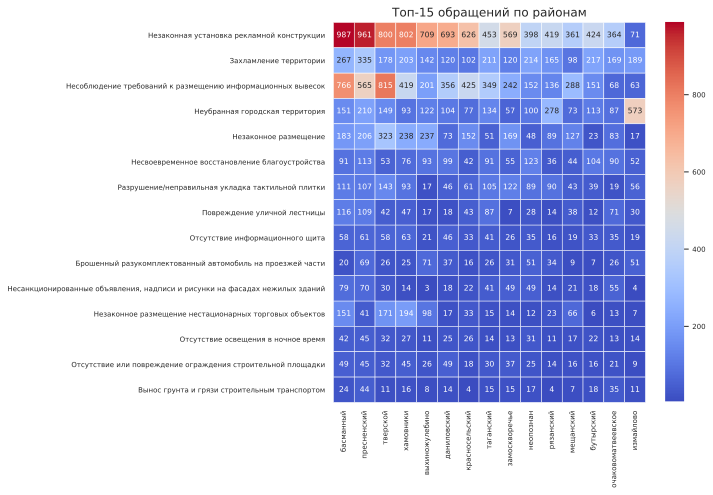

In [ ]:
# построим тепловую карту причин обращения и районов 
# дефолтная функция от организаторов не требует доработки или замены

area_problem_crosstab = (pd.crosstab(prepared['problem'], 
                                     prepared['area'])
                           .loc[prepared['problem'].value_counts()[:15].index,  
                                prepared['area'].value_counts()[:15].index])
plt.figure(figsize=(7,7))
sns.heatmap(area_problem_crosstab, cmap="coolwarm",
            annot=True, fmt=".0f", linewidths=.5)

plt.title('Топ-15 обращений по районам', size=12, y=1.02);

### 2.4 Генерация новых признаков  

Начнем с выделения экспрессивных выражений. Посчитаем количество восклицательных и вопросительных знаков в обращениях и разделим выборку на эмоциональные и нейтральные тексты.

Гипотеза - проверить количество сообщений, которое написано в экспрессивной манере. Проанализировать, как можно применять данную фичу. Возможно, не в тематическом моделировании, но в особенном отношении к таким обращениям.

In [ ]:
def count_punctuation(df):

  ''' 
  Создаем 2 списка. Первый - количество знаков вопроса и восклицания. 
  Второй - показывает, много ли эмойций вкладывает в сообщение человек, если количество специальных знаков в обращении больше или равно 5.
  '''

  punctuation = []
  is_agressive = []

  corpus = prepared['text'].values

  for i in range(len(corpus)):
    punctuation.append(len(re.findall(r'[\!\?]', corpus[i])))
    if punctuation[i] >= 5:
      is_agressive.append(1)
    elif punctuation[i] <= 5:
      is_agressive.append(0)

  df['punctuation'] = punctuation
  df['is_agressive'] = is_agressive
    
  return df

In [ ]:
prepared = count_punctuation(prepared)

In [ ]:
prepared.groupby('is_agressive')['is_agressive'].count()

is_agressive
0    88716
1      887
Name: is_agressive, dtype: int64

Экспрессивных сообщений всего 1% от общего количества.

Однако, иногда встречаются очень взволнованные ситуацией жители!!!!!!!!!!!!!!!!!!!

In [ ]:
plotly_barchart(data=prepared.groupby('area')['is_agressive'].sum().sort_values(ascending=False)[:15], 
                x='area', 
                y='is_agressive', 
                y_axis='Количество обращений', 
                title='Районы с самыми взволнованными сообщениями')

In [ ]:
gc.collect()

69905

Пока оставим этот признак для дальнейшего использования



---

Не только жалобы встречаются в исходном датасете. Так же присутствуют 30 строк по теме "благодарность". Возможно, в дальнейшем стоит исключить их из анализа, так как общая масса обращений - просьба к местной власти.

In [ ]:
len(prepared.query('problem == "Благодарность"'))

30

### 2.5 Создание "Мегатем"

Создадим мегатемы - корзины обращений

In [ ]:
prepared['problem'] = prepared['problem'].str.lower()

In [ ]:
def problem_bin(row):
  '''
  находим вхождения тематических токенов в тематику проблемы 
  выводим название корзины в отдельный столбец 
  '''

  if ('рекл' in row['problem'] or 'вывесок' in row['problem'] or 'информа' in row['problem'] or 'рисунки на фасадах' in row['problem'] or 'указат' in row['problem']
      or 'противоречия' in row['problem']):
    return 'реклама и указатели'

  elif ('захлам' in row['problem'] or 'неубр' in row['problem'] or 'Вынос гр' in row['problem'] or 'уборка мест' in row['problem'] 
        or 'за мусора' in row['problem'] or 'лагоустро' in row['problem'] or 'стройплощадки' in row['problem'] or 'снег' in row['problem'] or 'гололед' in row['problem']):
    return 'мусор и благоустройство'

  elif ('ждение уличн' in row['problem'] or 'тактильной' in row['problem'] or 'освещени' in row['problem'] or 'ограждения' in row['problem'] or 'неисправност' in row['problem']
        or 'наличие ям' in row['problem'] or 'ямы/выступы' in row['problem'] or 'ние детско' in row['problem'] or 'демонт' in row['problem']  or 'ненадле' in row['problem'] 
        or 'подтопление' in row['problem']):
    return 'ремонт и освещение'

  elif ('автомо' in row['problem']):
    return 'автомобили'

  elif ('торговых объектов' in row['problem'] or 'незакон' in row['problem'] or 'мигрантов' in row['problem'] or 'летних ка' in row['problem'] or 'самовол' in row['problem'] 
        or 'тов в парках' in row['problem'] or ''):
    return 'размещение'

  elif ('санитар' in row['problem'] or 'просроченных' in row['problem'] or 'табачной проду' in row['problem']):
    return 'санитария'

  else:
    return 'прочее'

In [ ]:
prepared['problem_bin'] = prepared.apply(problem_bin, axis=1)

In [ ]:
prepared['problem_bin'].value_counts().reset_index()

,index,problem_bin
0,реклама и указатели,37472
1,мусор и благоустройство,28777
2,ремонт и освещение,11872
3,размещение,7853
4,автомобили,1945
5,прочее,1236
6,санитария,448


In [ ]:
fig = px.pie(prepared['problem_bin'].value_counts().reset_index(), 
             values='problem_bin', 
             names='index', 
             title='Разбивка обращений по "мегатемам"',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='auto', 
                  textinfo='percent+label', 
                  title = {'position':'top center'}
                  )
fig.show()

Разбивка корретна. Напомним, что в первоначальном датасете имеем 89 тем. Мы снизили это количество вручную в 10 раз.

40 процентов обращений связаны с рекламой и указателями. Мусор и благоустройсво волнуют жителей Москвы в трети случаев. Ремонт и незаконное размещение объектов появляются в обращениях вместе в 20 процентах сообщений.

На этом заканчиваем предобработку районов.

-----

### 2.6 Обновление стоп-слов

Данный метод выполняется в связке с тематическим моделированием. Пайплайн выглядит так: мы удаляем дефолтные стоп-слова, строим базовую модель и смотрим, какие слова попали в ее описание. После этого обновляем список и добавляем него новые стоп-слова, которые встречаются часто, но не несут смысловой нагрузки. Например, "который, прошу, будьте добры". Данный подход требует дополнительно 3-4 раза прогнать базовую модель с обновленным корпусом, но повышает качество работы модели на 5-7%. Предварительные исследования стоп-слов в этой работе не показаны с целью удаления лишнего неинформативного кода.

In [ ]:
stopwords_extra = (["пожалуйста", "спасибо", "большое", "просьба", "прошу", "будьте", "добры", "затем", "почему", 'просить', "иной", "тот самый", "здравствуйте", "который", 'это', "то",
                    'год', "хочется", "хочу", "хотеть", "хотят", 'которые', "которая", "каждый", 'вообще', 'данный', "данные"])

for word in range(len(stopwords_extra)):
  stopwords.append(stopwords_extra[word])

# Данная строка сохраняет в списке стопслов только уникальные значение при нескольких итерациях алгоритма
#stopwords = list(set(stopwords)) 

In [ ]:
len(stopwords)

178

# 3. Тематическое Моделирование

In [ ]:
# готовим данные для lda

morph = pymorphy2.MorphAnalyzer()
tokens_ = (prepared['text'].str.lower().replace('[^а-я-ё]|-', ' ', regex=True)
                           .apply(lambda x: [morph.parse(word)[0].normal_form for word in x.split(' ')
                                            if len(word) > 2 and word not in stopwords])
                           ).tolist()

tokens, dictionary, all_corpus = prepare_lda_data(data=tokens_)

Перед моделированием, посмотрим на облако самых часто встречаемых лемматизированных слов в первых сообщениях

In [ ]:
long_texts = ''
for i in range(len(tokens)):
  long_texts += ','.join(word for word in tokens[1])

In [ ]:
len(long_texts)

23924001

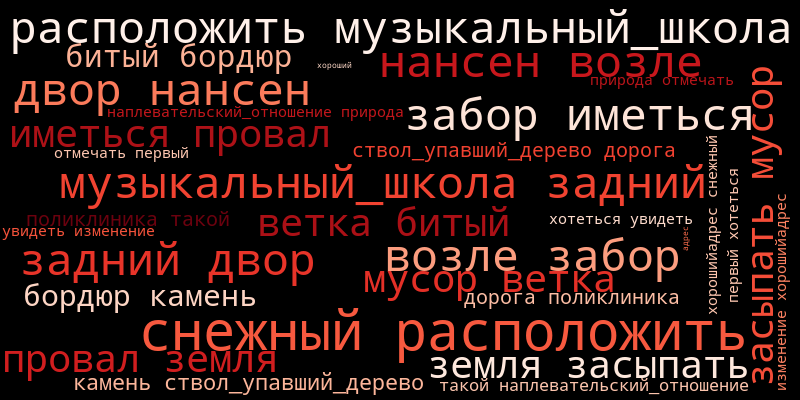

In [ ]:
# Строим облако слов

wordcloud = WordCloud(background_color="black", 
                      height=400,
                      width=800,
                      max_words=1000, 
                      contour_width=3, 
                      colormap='Reds',
                      random_state=SEED)

wordcloud.generate(long_texts)

wordcloud.to_image()

Мусор, и битый ветка, и наплевательское_отношение к природа, и что-то с задней стороны музыкальной школыю Это то, чем, в основном, недовольны москвичи.  

---

### 3.1 Latent Dirichlet allocation

Первой применим модель LDA - Латентное размещение Дирихле

In [ ]:
# В отличие от исходного ноутбука, мы применяем Мультикор модель без настройки гиперпараметров в первом приближении

lda_model = models.LdaMulticore(corpus=all_corpus,
                                       id2word=dictionary,
                                       num_topics=20, 
                                       random_state=SEED,
                                       chunksize=100,
                                       per_word_topics=True)

# посмотрим первые 10 слов по первым темам
lda_model.show_topics(num_topics=10, num_words=10, formatted=True)

[(1,
  '0.155*"информационный" + 0.061*"указанный" + 0.046*"городской" + 0.034*"висеть" + 0.031*"разместить_нарушение" + 0.029*"указатель" + 0.028*"требование_постановление_правительство_москва" + 0.024*"запретить" + 0.018*"исправить" + 0.017*"переход"'),
 (10,
  '0.067*"грязь" + 0.063*"находиться" + 0.054*"добрый_день" + 0.051*"расположить" + 0.043*"который" + 0.034*"уборка" + 0.027*"необходимо" + 0.021*"разобраться" + 0.018*"ребёнок" + 0.017*"удалить"'),
 (11,
  '0.087*"место" + 0.069*"установить" + 0.063*"рядом" + 0.051*"данный" + 0.043*"сообщение" + 0.040*"лежать" + 0.039*"магазин" + 0.023*"стоять" + 0.021*"неделя" + 0.016*"палатка"'),
 (9,
  '0.252*"вывеска" + 0.114*"размещение" + 0.043*"остаться" + 0.041*"фасад" + 0.026*"бросить" + 0.020*"мешок" + 0.019*"здание" + 0.017*"навести_порядок" + 0.014*"авто" + 0.014*"огромный"'),
 (12,
  '0.085*"забор" + 0.061*"принять_мера" + 0.025*"проезд" + 0.023*"нто" + 0.021*"яма" + 0.018*"организация" + 0.017*"покрытие" + 0.016*"метро" + 0.013*"о

Рассмотрим такую оценку модели, как согласованноть темы (topic coherence).  Описание когерентности (согласованности) работы тематической модели есть в [статье на Medium](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0). Чем ближе значение метрики к единице, тем лучше.  

Посмотрим на значение согласованности у базовой модельки.

In [ ]:
compute_coherence(model=lda_model, 
                  texts=tokens, 
                  dictionary=dictionary)

('Когерентность модели: ', 0.42380441230114674)

Невысокое значение. Подберем гиперпараметры.

In [ ]:
# Попробуем выжать больше, настроив гиперпараметры и поиграв разным с количеством тем

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Расчитаем согласованность тем для моделей с различным количеством тем
    На выходе получаем список моделей и метрику coherence_value для каждой из них
    """

    coherence_values = []
    model_list = []
    # Пробегаем циклом по списку количества тем
    for num_topics in range(start, limit, step):
        model = models.LdaMulticore(corpus=all_corpus, 
                                    num_topics=num_topics, 
                                    id2word=dictionary, 
                                    random_state=SEED,
                                    chunksize=100,
                                    alpha=0.9,
                                    eta=0.6,
                                    passes=2)
        # Сохраняем текущую модель и вычисляем для нее искомую метрику
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence='c_v')
        
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
'''
Примерное время выполнения ячейки - 15-18 минут 

В первом приближении мы рассматривали шаг количества тем = 5. Качество модели падало на 10% после прохождения порога в 15 тем и не превышало 0.46. 
Для более тонкой настройки выберем диапазон от 6 до 18 тем с шагом в 2 темы.
'''

model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=all_corpus, 
                                                        texts=tokens, 
                                                        start=6, 
                                                        limit=20, 
                                                        step=2)

In [ ]:
# Визуализируем coherence value и выбираем лучшую модель

num_topics = np.arange(6, 20, 2)

fig = go.Figure()
fig.add_trace(go.Scatter(x=num_topics, 
                         y=coherence_values,
                         line_shape='linear',
                         line=dict(color='salmon', width=3)))

fig.update_layout(template='plotly_white', 
                  title='Распределение Coherence Value')
fig.show()

Наилучшую метрику показала модель с 10 темами. Этот результат близок к количеству мегатем, которые мы выделили вручную. В нашем случаем было 7 тем - корзин. Выдвинем гипотезу, что для лучшей работы сервиса обращений граждан необходимо уменьшить количество возможным тем. Если данный подход не укладывается в философию продукта, предлагаем сделать подтемы в каждой "корзине", но не увеличивать количество основных тем. Дополнительным плюсом подхода станет удобство для пользователей, которые смогут сэкономить время для выбора темы и не ошибутся в текущем многообразии.

In [ ]:
# Утверждаем модель для дальнейшей работы

lda_final_model = model_list[2]

### 3.2 Анализ LDA 

In [ ]:
# Посмотрим на 10 главных слов по каждой выявленной теме

lda_final_model.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.023*"работа" + 0.020*"дать" + 0.019*"данный" + 0.019*"проблема" + 0.016*"вестись" + 0.016*"сообщение" + 0.015*"год" + 0.014*"объект" + 0.013*"который" + 0.013*"торговля"'),
 (1,
  '0.062*"улица" + 0.046*"тротуар" + 0.034*"плитка" + 0.031*"стоить" + 0.028*"находиться" + 0.021*"тактильный_плитка" + 0.021*"возле" + 0.019*"автомобиль" + 0.015*"остановка" + 0.015*"требовать"'),
 (2,
  '0.101*"вывеска" + 0.057*"информационный" + 0.044*"размещение" + 0.037*"несоблюдение_требование_размещение" + 0.036*"нарушение" + 0.031*"устранить" + 0.025*"принять_мера" + 0.025*"проверить" + 0.012*"москва" + 0.009*"снова"'),
 (3,
  '0.171*"конструкция" + 0.169*"рекламный" + 0.128*"незаконный" + 0.045*"демонтировать" + 0.027*"проверить_законность_размещение" + 0.024*"установка" + 0.023*"щит" + 0.019*"разместить" + 0.018*"штендер" + 0.016*"установить"'),
 (4,
  '0.119*"дом" + 0.076*"реклама" + 0.044*"адрес" + 0.034*"здание" + 0.031*"забор" + 0.028*"напротив" + 0.028*"рядом" + 0.021*"около" + 0.021*"д

Построим пузырьковый график тем. Цитата в описании модели приведена с сайта [webdevblog.ru](https://webdevblog.ru/tematicheskoe-modelirovanie-s-pomoshhju-gensim-python/)

In [ ]:
# Применим библиотеку pyLDAvis для визуализации разбивки текста по темам. 

'''
Каждый пузырь на левом графике представляет тему. Чем больше пузырь, тем больше распространена эта тема.
Хорошая тематическая модель будет иметь довольно большие непересекающиеся пузыри, разбросанные по всей диаграмме, а не сгруппированные в одном квадранте.
Модель со слишком большим количеством тем, как правило, имеет много перекрытий, пузырьки небольшого размера, сгруппированные в одной области диаграммы.
'''

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_final_model, all_corpus, dictionary)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.043431 -0.070228       1        1  12.017047
5     -0.083773 -0.051654       2        1  11.136015
6     -0.072455  0.324054       3        1  10.893084
8     -0.095115 -0.036512       4        1  10.712244
4     -0.001050 -0.087134       5        1  10.113252
9     -0.062137  0.050695       6        1   9.377855
3      0.367951  0.048760       7        1   9.352489
1     -0.058502 -0.061024       8        1   9.224135
2      0.059360 -0.101019       9        1   8.915165
7     -0.010847 -0.015938      10        1   8.258713, topic_info=                  Term          Freq         Total Category  logprob  loglift
16               мусор  11439.000000  11439.000000  Default  30.0000  30.0000
57         конструкция  10664.000000  10664.000000  Default  29.0000  29.0000
91           рекламный  10542.000000  10542.000000  Default  28.0000  28.0000
94          незаконный   7971.000000   7971.000000  Default  27.0000  27.0000
214         территория   8290.000000   8290.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
1167  проводить_работа    190.008424    196.702326  Topic10  -5.6710   2.4593
1099          компания    208.337539    215.990150  Topic10  -5.5789   2.4578
1736             иметь    265.960103    280.903411  Topic10  -5.3347   2.4392
723             стекло    262.018324    283.570617  Topic10  -5.3496   2.4149
121         установить    971.426499   1966.157525  Topic10  -4.0393   1.7888

[385 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
773       1  0.003038  авто
773       2  0.003038  авто
773       3  0.003038  авто
773       4  0.003038  авто
773       5  0.003038  авто
...     ...       ...   ...
342       5  0.001797   яма
342       6  0.001797   яма
342       8  0.001797   яма
342       9  0.001797   яма
342      10  0.001797   яма

[3274 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 7, 9, 5, 10, 4, 2, 3, 8])

Разнести темы всей поверхности диаграммы не совсем получилось. Однако, результат удовлетворительный.  
Мы так же наблюдаем небольшое количество биграмм и триграмм в обращениях. С одной стороны, это богатство русского языка и количество словестных оборотов. С другой - обращения отличаются друг от друга.

In [ ]:
def format_topics_sentences_multicore(ldamodel=lda_model, corpus=corpus, texts=data):
    ''' Функция для выделения ключевых слов и доминирующей темы в каждом сообщении '''

    # Инициализируем будущий результат в виде таблицы
    sent_topics_df = pd.DataFrame()
    # Находим главную тему каждого документа
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Получаем доминантную тему, распределение слов и ключевые слова для каждого документа
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Доминантная тема
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Добавляем в финальную таблицу исходный текст обращения
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
  
    return sent_topics_df 

In [ ]:
# Рассмотрим доминирующую тему в каждом обращении
# Время выполнения ячейки ~ 15 минут

df_topic_sents_keywords = format_topics_sentences_multicore(ldamodel=lda_final_model,
                                                            corpus=all_corpus,
                                                            texts=prepared['text'].tolist())

df_dominant_topic = df_topic_sents_keywords.reset_index(drop=True)
df_dominant_topic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(10)

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,2.0,0.1070,"вывеска, информационный, размещение, несоблюдение_требование_размещение, нарушение, устранить, п...",выше второго этажа
1,5.0,0.1653,"лестница, двор, один, ремонт, сделать, подъезд, состояние, два, человек, ступень",по адресу снежная д24 расположена музыкальная школа .на заднем дворе по пр.нансена возле забор...
2,8.0,0.3047,"сторона, работа, дорога, грязь, восстановить, проезжий_часть, весь, переулок, вдоль, асфальт",после проведения работ на кабельной канализации мгтс запорные устройства (железобетонные пробки)...
3,7.0,0.1607,"отсутствовать, ограждение, информационный_щит, освещение, стройка, строительство, строительный_п...",очистите опору освещения. приведите в надлежащее состояние.
4,9.0,0.2601,"убрать, место, газон, фото, лежать, остаться, земля, парковка, часть, валяться",более двух недель лежит куча грунта в перемешку с мусором
5,9.0,0.2218,"убрать, место, газон, фото, лежать, остаться, земля, парковка, часть, валяться","осколки бордюрного камня спрятаны за дерево, ветки деревьев на земле"
6,2.0,0.2606,"вывеска, информационный, размещение, несоблюдение_требование_размещение, нарушение, устранить, п...",прошу рассмотреть законность размещения вывески \\
7,3.0,0.2416,"конструкция, рекламный, незаконный, демонтировать, проверить_законность_размещение, установка, щ...",просьба проверить законность размещения информационной конструкции \\
8,2.0,0.1965,"вывеска, информационный, размещение, несоблюдение_требование_размещение, нарушение, устранить, п...",здравствуйте! прошу проверить законность установки информационной вывески по адресу снежная улиц...
9,7.0,0.2697,"отсутствовать, ограждение, информационный_щит, освещение, стройка, строительство, строительный_п...",отсутствуют информационные щиты на всех подобных площадках по замене остановок в свиблово.


In [ ]:
# Посмотрим самые репрезенативные сообщени по каждой сформированной теме

topics_sorted = pd.DataFrame()

topics_out = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in topics_out:
    topics_sorted = pd.concat([topics_sorted, 
                               grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                               axis=0)
    
topics_sorted.reset_index(drop=True, inplace=True)
topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

topics_sorted

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7167,"работа, дать, данный, проблема, вестись, сообщение, год, объект, который, торговля","жители устали писать по данной проблеме. было написано уже три сообщения за № 17458339,17551832,..."
1,1.0,0.6290,"улица, тротуар, плитка, стоить, находиться, тактильный_плитка, возле, автомобиль, остановка, тре...","возле въезда в гск стоит грузовая газель кузов белый. авто имеет все признаки бртс: номеров нет,..."
2,2.0,0.7739,"вывеска, информационный, размещение, несоблюдение_требование_размещение, нарушение, устранить, п...","в случае размещения вывесок на внешних поверхностях зданий, строений, сооружений нарушениями тре..."
3,3.0,0.5443,"конструкция, рекламный, незаконный, демонтировать, проверить_законность_размещение, установка, щ...","прошу\\n\\n1) демонтировать рекламную конструкцию «мосцветторг», незаконно установленную на стол..."
4,4.0,0.5193,"дом, реклама, адрес, здание, забор, напротив, рядом, около, добрый_день, расположить","реклама висит в нарушение закона.окна заклеены или завешены рекламой, вертикальныая реклама и т.д."
5,5.0,0.7345,"лестница, двор, один, ремонт, сделать, подъезд, состояние, два, человек, ступень","сделали красивую лестницу с красивым пандусом и вроде бы всё здорово, а не тут то было. не понят..."
6,6.0,0.6773,"мусор, территория, строительный, захламление, городской, куча, захламить, уборка, свалка, хлам",здравствуйте.\\nна природоохраняемой территории оопт «пип тушинский» (за ул. саломеи нерис) на с...
7,7.0,0.5676,"отсутствовать, ограждение, информационный_щит, освещение, стройка, строительство, строительный_п...",при въезде на строительную площадку и выезде с нее должны быть оборудованы информационные щиты с...
8,8.0,0.5987,"сторона, работа, дорога, грязь, восстановить, проезжий_часть, весь, переулок, вдоль, асфальт","был перерыт участок тротуара. работы закончены более месяца назад, но асфальтовое покрытие до си..."
9,9.0,0.5055,"убрать, место, газон, фото, лежать, остаться, земля, парковка, часть, валяться","черный джип рэндж ровер. номера с841рт197. авто имеет признаки бртс: колеса вросли в землю, одно..."


Посмотрим на финальное распределение тем после обработки во всем корпусе обращений.

In [ ]:
# Создаем три переменных - количество обращений по темам, процентное соотнешие и ключевые слова каждой темы
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Соединяем данные в один датасет
temp = topic_counts.reset_index().merge(topic_contribution.reset_index(), on='index')
temp.columns = ['Dominant_Topic', 'Num_Documents', 'Perc_Documents']
topics_contribution = pd.merge(temp, topic_num_keywords, on='Dominant_Topic', how='left').drop_duplicates().reset_index(drop=True).sort_values('Num_Documents', ascending=False)

topics_contribution

,Dominant_Topic,Num_Documents,Perc_Documents,Topic_Keywords
0,3.0,17860,0.1993,"конструкция, рекламный, незаконный, демонтировать, проверить_законность_размещение, установка, щ..."
1,6.0,13208,0.1474,"мусор, территория, строительный, захламление, городской, куча, захламить, уборка, свалка, хлам"
2,2.0,9507,0.1061,"вывеска, информационный, размещение, несоблюдение_требование_размещение, нарушение, устранить, п..."
3,4.0,8997,0.1004,"дом, реклама, адрес, здание, забор, напротив, рядом, около, добрый_день, расположить"
4,0.0,7483,0.0835,"работа, дать, данный, проблема, вестись, сообщение, год, объект, который, торговля"
5,1.0,7048,0.0787,"улица, тротуар, плитка, стоить, находиться, тактильный_плитка, возле, автомобиль, остановка, тре..."
6,7.0,6751,0.0753,"отсутствовать, ограждение, информационный_щит, освещение, стройка, строительство, строительный_п..."
7,8.0,6492,0.0725,"сторона, работа, дорога, грязь, восстановить, проезжий_часть, весь, переулок, вдоль, асфальт"
8,9.0,6148,0.0686,"убрать, место, газон, фото, лежать, остаться, земля, парковка, часть, валяться"
9,5.0,6109,0.0682,"лестница, двор, один, ремонт, сделать, подъезд, состояние, два, человек, ступень"


Посмотрим на ключевые слова и дадим названия смоделированным темам. Некоторые темы пересекаются по смыслу. Ручное именование тем может быть не слишком качественным.

In [ ]:
'''

ВАЖНО! 

При реранах ноутбука модель LDA может выдавать небольшие отклонения в номерах финальных тем, даже с установленным random_state
При перезапуске ноутбука требуется ручная проверка и настройка словаря тем

'''

topic_dict = {0.0:'торговля',
              1.0:'дорожное покрытие',
              2.0:'размещение вывесок',
              3.0:'незаконные вывески',
              4.0:'проблемы с рекламой',
              5.0:'ремонт, лестницы',
              6.0:'свалка',
              7.0:'освещение',
              8.0:'грязь и мусор',
              9.0:'уборка территории'}

df_dominant_topic['Topic_Name'] = df_dominant_topic['Dominant_Topic']

df_dominant_topic['Topic_Name'].replace(topic_dict, inplace=True)

df_dominant_topic['Area'] = prepared['area']

df_dominant_topic.head()

,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Topic_Name,Area
0,2.0,0.1070,"вывеска, информационный, размещение, несоблюдение_требование_размещение, нарушение, устранить, п...",выше второго этажа,размещение вывесок,свиблово
1,5.0,0.1653,"лестница, двор, один, ремонт, сделать, подъезд, состояние, два, человек, ступень",по адресу снежная д24 расположена музыкальная школа .на заднем дворе по пр.нансена возле забор...,"ремонт, лестницы",свиблово
2,8.0,0.3047,"сторона, работа, дорога, грязь, восстановить, проезжий_часть, весь, переулок, вдоль, асфальт",после проведения работ на кабельной канализации мгтс запорные устройства (железобетонные пробки)...,грязь и мусор,свиблово
3,7.0,0.1607,"отсутствовать, ограждение, информационный_щит, освещение, стройка, строительство, строительный_п...",очистите опору освещения. приведите в надлежащее состояние.,освещение,свиблово
4,9.0,0.2601,"убрать, место, газон, фото, лежать, остаться, земля, парковка, часть, валяться",более двух недель лежит куча грунта в перемешку с мусором,уборка территории,свиблово


Посмотрим на распределение новых тем по годам

In [ ]:
grouped_problem_lda

,Topic_Name,year,Dominant_Topic
0,грязь и мусор,2012,26
1,грязь и мусор,2013,140
2,грязь и мусор,2014,381
3,грязь и мусор,2015,458
4,грязь и мусор,2016,692
...,...,...,...
96,уборка территории,2017,895
97,уборка территории,2018,606
98,уборка территории,2019,1336
99,уборка территории,2020,1714


In [ ]:
# Собираем данные для анализа
df_dominant_topic['year'] = prepared['year']
grouped_problem_lda = df_dominant_topic.groupby(['Topic_Name','year'])['Dominant_Topic'].count().reset_index()

# Отрисовываем график
fig = px.area(grouped_problem_lda, 
              x="year", 
              y="Dominant_Topic", 
              color="Topic_Name")

fig.update_layout(title_text='Динамика количества обращений по главным темам по годам',
                    template='plotly_white',
                    xaxis=dict(
                        title=None,
                        titlefont_size=10,
                        tickfont_size=10),
                    yaxis=dict(
                      title='Обращения',
                      titlefont_size=12,
                      tickfont_size=14)
                   )
fig.show()

Новая разбивка демонстрирует несколько отличную картину, чем график исходных тем. Теперь заметен практически равномерное движение каждой мегатемы по годам.  

---


Нанесем количество обращений по теме 3 на карту Москвы и посмотрим распределения. Такое представление проблемы поможет управленцам лучше принимать решения и мониторить ситуацию в городе.

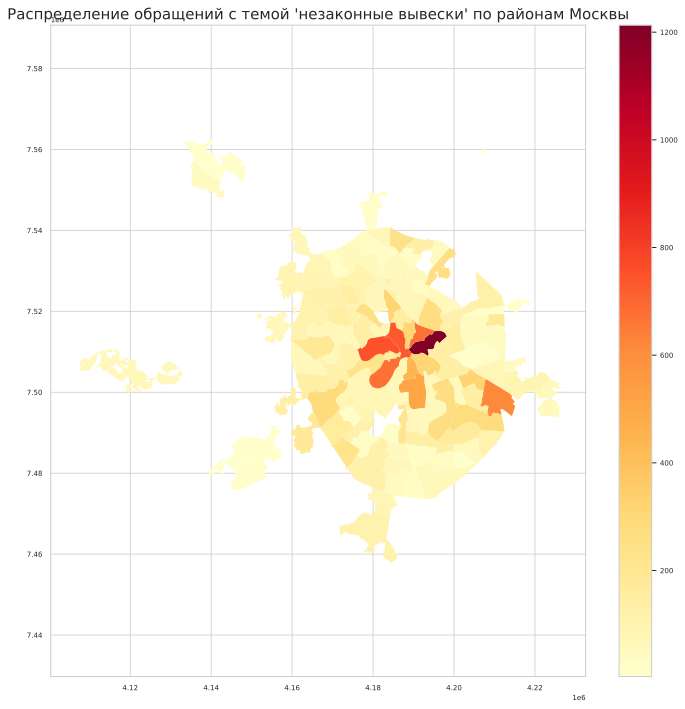

In [ ]:
plot_area(3.0)

Посмотрим, как покажет себя модель на новых сообщениях

In [ ]:
topic_example('Куча мусора возле парадной')

'свалка'

In [ ]:
topic_example('Реклама, реклама, сплошная незаконная реклама')

'проблемы с рекламой'

In [ ]:
topic_example('Непрекращающаяся уже третий год стройка мешает моему верному псу спокойно спать')

'ремонт, лестницы'

### 3.3 Разбивка тем на подтемы с помощью LDA

При необходимости распределить сообщения каждой крупной темы на несколько дополнительных тем, предлагаем применить модель lda к каждой подруппе. В данной работе приведем пример работы с одной мегатемой, например, номер 6.

In [ ]:
# Добавляем лемматизированный текст обращения к датасету и выделяем интересующую группу

topic_ten = df_dominant_topic[['Dominant_Topic']].copy()
topic_ten['lemmas'] = tokens_
topic_ten['tokens'] = tokens
#topic_ten['dict'] = dictionary
topic_ten['corpus'] = all_corpus
topic_ten = topic_ten.query('Dominant_Topic == 6.0')
topic_ten.shape

(13208, 4)

In [ ]:
# Запускаем новую lda модель на подгруппе

lda_model_ten = models.LdaMulticore(corpus=topic_ten['corpus'],
                                       id2word=dictionary,
                                       num_topics=10, 
                                       random_state=SEED,
                                       chunksize=100,
                                       per_word_topics=True)

# посмотрим первые 10 слов по первым темам
lda_model_ten.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.071*"мусор" + 0.057*"убираться" + 0.041*"убирать" + 0.035*"территория" + 0.025*"дом" + 0.025*"грунт" + 0.023*"вокруг" + 0.022*"садик" + 0.017*"урна" + 0.016*"устроить_свалка"'),
 (1,
  '0.095*"территория" + 0.084*"мусор" + 0.043*"городской" + 0.042*"завалить" + 0.029*"участок" + 0.028*"весь" + 0.026*"навести_порядок" + 0.025*"убрать" + 0.020*"грязь" + 0.018*"вывезти"'),
 (2,
  '0.050*"около" + 0.045*"дом" + 0.025*"улица" + 0.023*"стройка" + 0.018*"привести" + 0.018*"мкад" + 0.017*"рядом" + 0.017*"вход" + 0.017*"подъезд" + 0.015*"двор"'),
 (3,
  '0.072*"мусор" + 0.069*"гора" + 0.025*"контейнер" + 0.023*"складирование" + 0.020*"площадка" + 0.019*"два_неделя" + 0.017*"дерево" + 0.016*"никто_убирать" + 0.013*"полностью" + 0.012*"пакет"'),
 (4,
  '0.067*"мусор" + 0.051*"мешок" + 0.050*"листва" + 0.030*"работа" + 0.027*"парк" + 0.026*"уборка" + 0.020*"день" + 0.019*"именно" + 0.017*"химический" + 0.012*"парка"'),
 (5,
  '0.260*"территория" + 0.082*"захламление" + 0.074*"захламить" 

In [ ]:
compute_coherence(model=lda_model_ten, 
                  texts=topic_ten['tokens'], 
                  dictionary=dictionary)

('Когерентность модели: ', 0.36360313409986295)

In [ ]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_ten, topic_ten['corpus'], dictionary)

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.264672  0.032411       1        1  14.219905
1     -0.174467  0.067629       2        1  12.670399
9     -0.067417 -0.180531       3        1  11.090876
2      0.088265  0.265876       4        1  10.750325
0      0.004006  0.129516       5        1   9.657857
6     -0.051445 -0.121751       6        1   9.280680
8      0.122533 -0.036489       7        1   9.101206
7      0.115697 -0.023371       8        1   8.873509
3      0.129847 -0.057525       9        1   7.466796
4      0.097652 -0.075767      10        1   6.888447, topic_info=             Term         Freq        Total Category  logprob  loglift
214    территория  5834.000000  5834.000000  Default  30.0000  30.0000
100  строительный  2157.000000  2157.000000  Default  29.0000  29.0000
898   захламление  1227.000000  1227.000000  Default  28.0000  28.0000
478     захламить  1120.000000  1120.000000  Default  27.0000  27.0000
16          мусор  8854.000000  8854.000000  Default  26.0000  26.0000
..            ...          ...          ...      ...      ...      ...
230        уборка   191.643997   623.712956  Topic10  -3.6376   1.4953
16          мусор   489.151761  8854.684661  Topic10  -2.7006  -0.2207
8           забор    60.011002   370.895935  Topic10  -4.7987   0.8539
913         доска    35.980968   114.643039  Topic10  -5.3103   1.5165
119         район    35.447250   148.760634  Topic10  -5.3252   1.2410

[467 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3016      1  0.004131  аварийный
3016      2  0.066102  аварийный
3016      4  0.132204  аварийный
3016      5  0.057839  аварийный
3016      6  0.289196  аварийный
...     ...       ...        ...
1095     10  0.995426      школа
1409      6  0.994542     щебень
268       5  0.949407       этот
268       9  0.046597       этот
572       3  0.962894   являться

[612 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 10, 3, 1, 7, 9, 8, 4, 5])

Мы видим, что пузырьки на диаграмме распологаются относительно равномерно. Несмотря на невысокий уровень когерентности модели, мы смогли разделить большую тему на несколько подтем. Данный метод можно представить заказчику для обсуждения дальнейшего исследования.


Построим граф, который отображает зависимость между подтемами. Затем перейдем к новой модели.

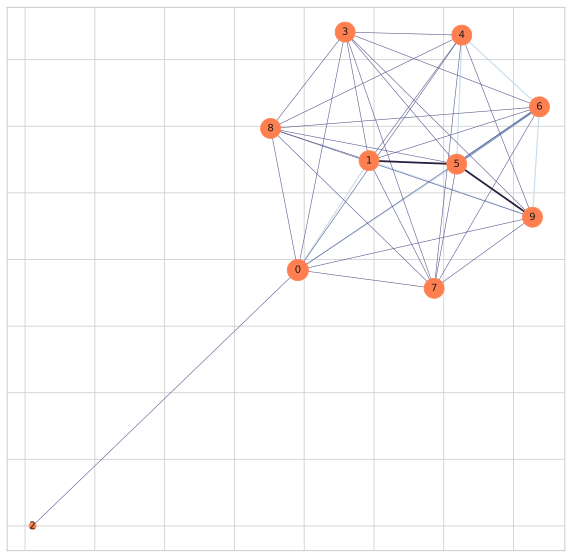

In [ ]:
built_graph(lda_model_ten)

In [ ]:
gc.collect()

178959

### 3.4 Non-Negative Matrix Factorization (NMF)  

Применим модель позитивной матричной факторизации. Подробное описание работы есть [здесь](https://blog.acolyer.org/2019/02/18/the-why-and-how-of-nonnegative-matrix-factorization/) 

In [ ]:
# Создаем корпус из лемматизированных ранее текстов для tfidf векторизации
texts = []

for i in range(len(tokens_)):
  texts.append(' '.join(tokens_[i]))

In [ ]:
# Производим векторизацию

tfidf_vect = TfidfVectorizer(max_features=7000,
                             min_df=1,
                             max_df=0.05,
                             stop_words=stopwords)

doc_term_matrix = tfidf_vect.fit_transform(texts)

In [ ]:
# Применяем модель Non-Negative Matrix Factorization к векторизованному корпусу

nmf = NMF(n_components=15,
          alpha=0.3,
          l1_ratio=0.3,
          max_iter=5000,
          tol=1e-3,
          random_state=SEED)

nmf.fit(doc_term_matrix)

NMF(alpha=0.3, beta_loss='frobenius', init=None, l1_ratio=0.3, max_iter=5000,
    n_components=15, random_state=42, shuffle=False, solver='cd', tol=0.001,
    verbose=0)

In [ ]:
# Визуализируем результаты

nfm_num_topic = []
nmf_keywords = []

for i, topic in enumerate(nmf.components_):
    nfm_num_topic.append(i)
    nmf_keywords.append([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])

nfm_topics_keywords = pd.DataFrame(data={'topics':nfm_num_topic, 'keywords':nmf_keywords})
nfm_topics_keywords

,topics,keywords
0,0,"[шоссе, переулок, случай, ярославский, день, добрый, дать, законный, адрес, установка]"
1,1,"[устранить, правило, отвечать, указанный, москва, требование, правительство, разместить, постано..."
2,2,"[енисейский, требоваться, необходимо, складный, отвечать, разместить, установить, установленный,..."
3,3,"[обращаться, нарушение, фото, решить, результат, подтверждать, провести, проверка, проблема, уст..."
4,4,"[вестись, похожий, отсутствие, складный, информация, раскладушка, установить, отсутствовать, инф..."
5,5,"[укладка, лестница, заменить, разбитый, тротуар, разрушение, разрушить, повредить, тактильный, п..."
6,6,"[прилагать, обязать, магазин, демонтаж, вход, установленный, удалить, незаконно, установить, ште..."
7,7,"[различный, фото, обращаться, отход, бетонный, бытовой, блок, устранить, городской, захламление]"
8,8,"[бросить, асфальт, благоустройство, куча, ограждение, тротуар, блок, бетонный, восстановить, газон]"
9,9,"[сторона, жилой, объявление, нежилой, вандальный, несанкционированный, рисунок, надпись, здание,..."


### 3.5 Анализ работы NFM модели

In [ ]:
# Сравним распределение по темам nfm модели и ручного именования

topic_values = nmf.transform(doc_term_matrix)
nfm_topics = prepared[['problem','text']].copy()
nfm_topics['topics'] = topic_values.argmax(axis=1)

nfm_topics

,problem,text,topics
0,несоблюдение требований к размещению информационных вывесок,выше второго этажа,0
1,неубранная городская территория,по адресу снежная д24 расположена музыкальная школа .на заднем дворе по пр.нансена возле забор...,14
2,неубранная городская территория,после проведения работ на кабельной канализации мгтс запорные устройства (железобетонные пробки)...,8
3,неубранная городская территория,очистите опору освещения. приведите в надлежащее состояние.,11
4,захламление территории,более двух недель лежит куча грунта в перемешку с мусором,8
...,...,...,...
89598,разрушение/неправильная укладка тактильной плитки,"разрушена тактильная плитка, опасно торчат углы. просьба исправить",5
89599,захламление территории,"открытые упаковки реагентов, часть реагентов рассыпана на асфальт, лопаты, просто мусор. уберите...",8
89600,незаконная установка рекламной конструкции,незаконная растяжка со стороны 1-го кадашевского переулка.,9
89601,незаконная установка рекламной конструкции,несоблюдение требований к размещению информационных вывесок.,12


In [ ]:
# Посмотрим на распределение документов

nfm_count = nfm_topics.groupby('topics')['text'].count().reset_index()
nfm_count['perc'] = round(nfm_count['text']/nfm_count['text'].sum(), 4)
nfm_count.columns = ['topic', 'docs', 'perc']
nfm_count.sort_values('docs', ascending=False)

,topic,docs,perc
8,8,23609,0.2635
0,0,13498,0.1506
5,5,6916,0.0772
9,9,5857,0.0654
11,11,5282,0.0589
13,13,4893,0.0546
1,1,4671,0.0521
3,3,4370,0.0488
4,4,3671,0.0410
12,12,3643,0.0407


In [ ]:
# Лидируют тема 8 и 0. Предположим, что это мусор и реклама.

nfm_topics.query('topics == 8')['problem'].value_counts()[:10]

захламление территории                                         6838
неубранная городская территория                                4995
несвоевременное восстановление благоустройства                 3616
брошенный разукомплектованный автомобиль на проезжей части     1369
незаконная установка рекламной конструкции                     1290
вынос грунта и грязи строительным транспортом                   799
неудовлетворительная уборка места проведения работ              632
повреждение уличной лестницы                                    517
незаконное размещение                                           484
отсутствие или повреждение ограждения строительной площадки     392
Name: problem, dtype: int64

Видно, что в распределении модели NFM в тему с хламом попадает реклама и ремонт. Данных ошибок при использовании LDA значительно меньше.

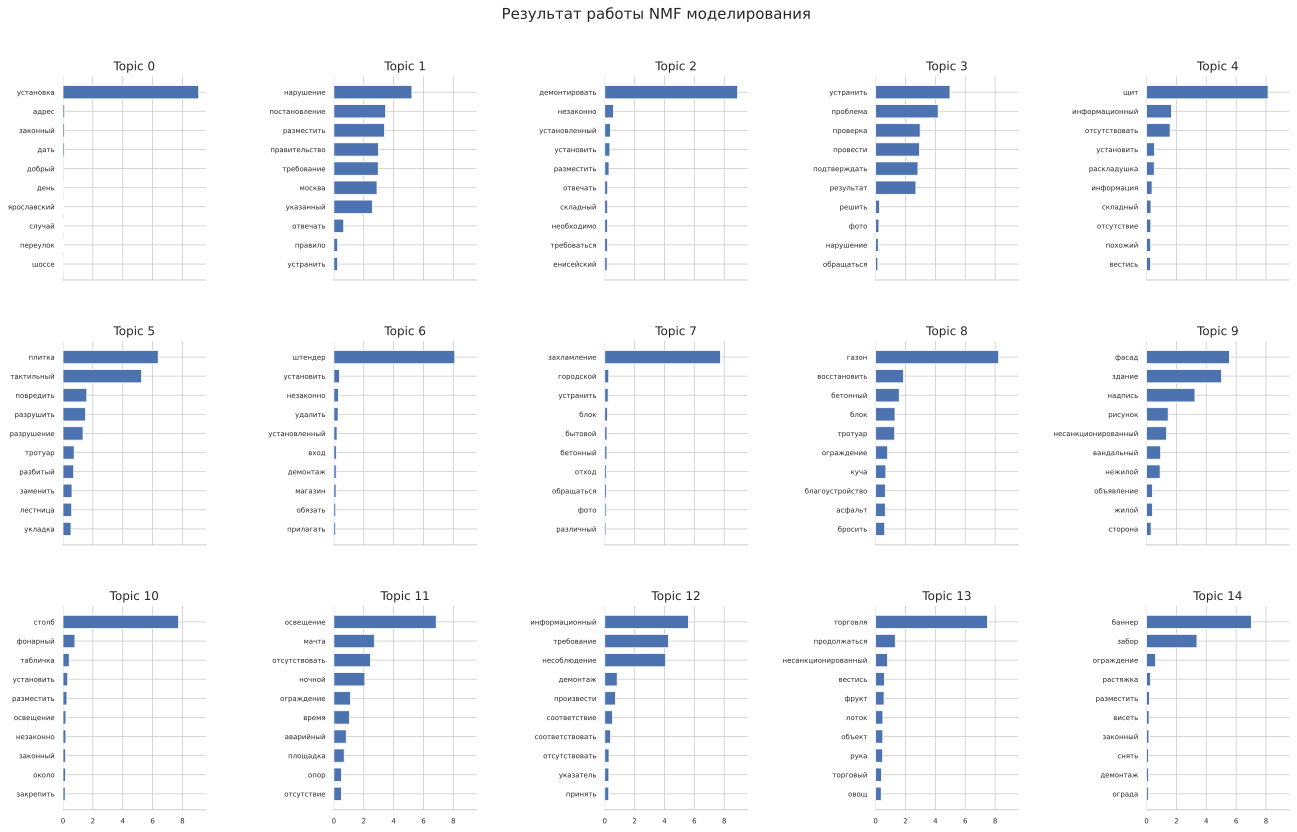

In [ ]:
# Отрисуем топ-10 слов по каждой теме NMF

tfidf_feature_names = tfidf_vect.get_feature_names()
plot_top_words(nmf, 
               tfidf_feature_names, 
               10,
               'Результат работы NMF моделирования')

In [ ]:
nmf_example('свалка свалка опять мусор И грязь. Сколько можно!!!!!')

'Номер темы: 8'

In [ ]:
nmf_example('Пропало освещение! Свет вообще появится когда-нибудь????????!!!')

'Номер темы: 11'

In [ ]:
nmf_example('Опять незаконно наставили своих палаток и торгуют гнилыми овощами')

'Номер темы: 13'

NMF модель демонстрирует неплохие результаты. Заметно, что реклама и мусорные проблемы разнесены по нескольким темам. Так же выделены проблемы освещения и рисунков на фасадах.  

Бесспорным плюсом NMF модели является скорость ее работы. 10-15 секунд и сообщения распределены по корзинам. LDA, особенно с поиском гиперпараметров, работает гораздо дольше. Однако, результаты lda модели проще визуализировать и мы получаем больше полезных статистических данных.   

Мы оставляем оба подхода, как возможные решения проблемы классификации обращений.


---

# Вывод 

Цель конкруса заключалась в распределении обращений граждан к мэру Москвы по темам. Мы предложили два подхода - тематические модели LDA и NMF. Оба метода обладают значительной ранжирующей способностью и продемонстрировали удовлетворительные результаты.   

  
В начале исследования мы провели глубокую предобработку исходных данных. В первой версии ноутбука значилось 4,5 тысяч неизвестных районов. С помощью регулярных выражений и ручного тюнинга мы выявили три тысячи районов и восстановили более 2 тысяч названий улиц. Неопознанными остались адреса всего 1600 сообщений. Разработанные алгоритмы помогут повысить качество работы портала.   
  
Мы провели глубокий анализ и создали функции для выявление повторных обращений, провели исследование длины обращений и рассмотрели экспрессивные сообщения, доля которых не превышала один процент, но которые, на наш взгляд, очень важны. Дополнительно мы вручную разбили все сообщения на 7 "мегатем". Этот подход оказался очень близок к тому, что продемонстрировали модели машинного обучения.

Результатами тематического моделирования стало применение двух моделей. Первая - Latent Dirichlet Allocation удобна в применение, позволяет визуализировать данные и дополнительную аналитику по темам, но требует длительного времени обучения и предсказания. С помощью неё мы выделили 10 основных тем, по которым и предлагаем совершать общее разделение. Если требуется разветвление крупной темы на подтемы, мы предлагаем использовать эту же модель, но на сгруппированных по темам сообщениях. Приведенный в работе пример разбивки крупной темы с рекламой на несколько "дочек" продемонстрировал высокие результаты работы.

Вторая модель, которую мы применили - Non-Negative Matrix Factorization, в 10 раз быстрее обрабатывает данные и требует меньших вычислительных затрат. Однако, она сложна в визуализации результатов и в расчете финальной метрики. Мы установили, что на текущих данных - идеальное количество тем, при использовании метода NMF = 15.  

Основной вывод исследования: 89 исходных тем - избыточное количество в первом приближении. Жителям, которые обращаюся в приемную мэра сложнее выбрать правильную категорию, операторы тратят больше времени на обработку обращений. Большое число тем сложнее визуализировать и анализировать. В основном, жителей Москвы, наверное, как и других городов, беспокоит мусор, ремонт, реклама и незаконная торговля. Для повышения качества работы сервиса предлагаем сократить количество первичных тем обращений до 12-15. При необходимости можно создать список подтем, применив указанные в работе алгоритмы.  

Из списка метрик [kpi](http://publication.pravo.gov.ru/Document/View/0001202102040027?index=3&rangeSize=1) государственных служащих можно выбрать 2 основных пункта, которые применимы к текущему набору обращений. Это качество городской и окружающей среды. Мы не имеем доступа к данным о скорости решения каждого обращения, но можем просто проследить динамику количества сообщений по данным темам. Дополнительно мы создали скрипт удобной визуализации количества обращений с определенными темами по районам Москвы. Так мы хотим помочь градоначальникам проще ориентироваться в масштабах основных проблем.

В заключении отметим, что нам бы хотелось найти применение разработанных методов в реальной помощи жителям городов!
